**Accessing POWER Monthly Meteorology - Earth Skin Surface Temperature (TS) Image Service Data**

This document performs a quick demonstration using NASA Earthdata Image Services in Python, focusing in on the Prediction of Worldwide Energy Resources (commonly known as POWER) annual meteorology dataset.  While primarily relying on the *ArcGIS API for Python*, this document also will briefly acknowledge some of the other potential libraries folks may utilize for visualization and analytics. While not demonstrated in this document, it is worth nothing some specific services – such as the POWER service tested below – also have [separate APIs](https://power.larc.nasa.gov/docs/services/api/) that can be called upon using their own schema.

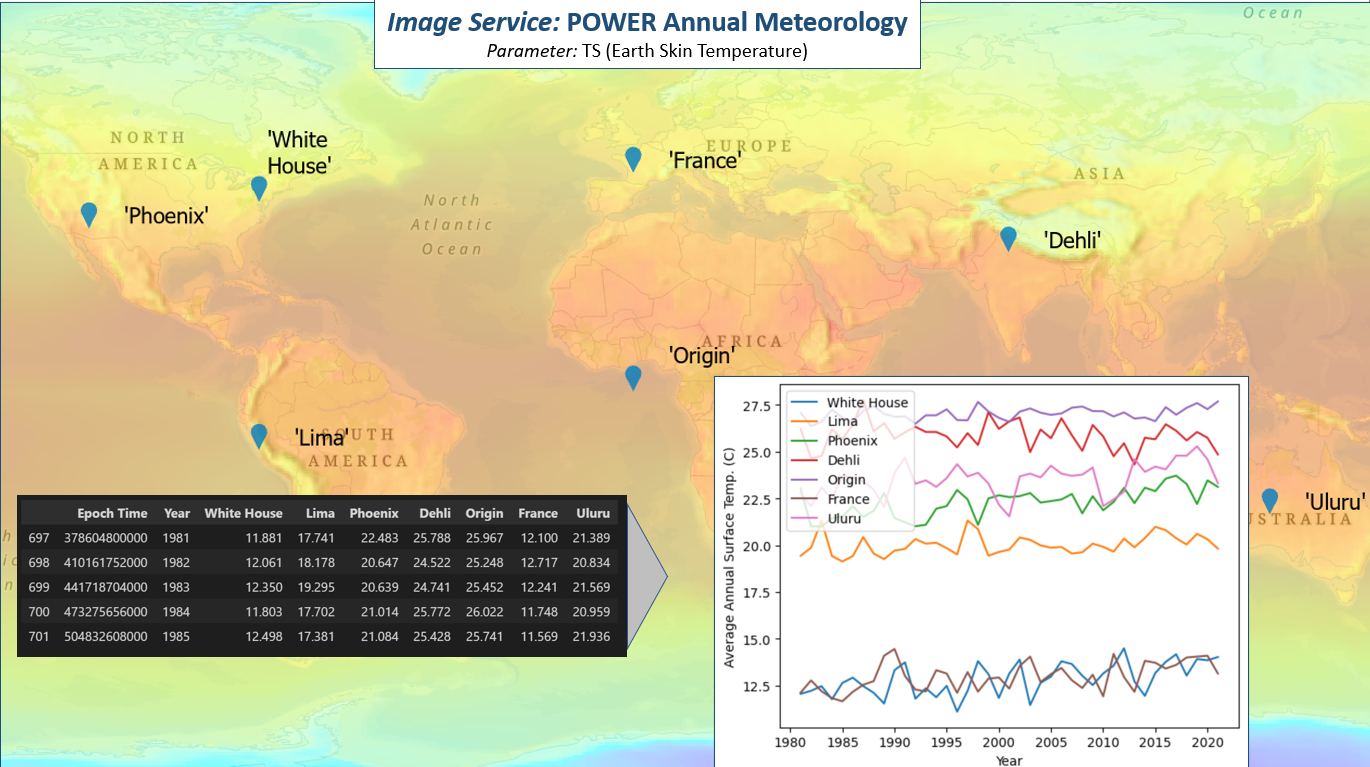

For this demo, we will be taking a look at surface temperature at 7 locations around the world and plot their data across over 40 years. We will do this by pinging the [NASA POWER annual meteorology](https://gis.earthdata.nasa.gov/portal/home/webmap/viewer.html?layers=525f42d17c6c4d9da5f359ca9ab7791f) datasets’ Earth Skin Temperature parameter (TS).

Getting started, we are going to take a look at the parameter information to familiarize ourselves with the structure of the dataset. We collect multidimensional information from the REST endpoint’s capabilities using the Python library [*requests*](https://pypi.org/project/requests/), which returns a json that has most of the numerical data in a non-geospatial format, including descriptive variable metadata, dimensions, and values. We start using requests for the sake of sampling some different ways to access this data, but this information could also be acquired using the *ArcGIS API for Python* access the slices class of the [ImageryLayer object](developers.arcgis.com/python/api-reference/arcgis.raster.toc.html) which we will be doing again below.

In [89]:
import requests

service_url = 'https://gis.earthdata.nasa.gov/image/rest/services/POWER/POWER_901_ANNUAL_METEOROLOGY_UTC/ImageServer'
url = service_url+'/multiDimensionalInfo?returnDimensionValues=always&f=pjson'

r = requests.get(url)
display(r.json()['multidimensionalInfo']['variables'][0].keys())
display(r.json()['multidimensionalInfo']['variables'][0])

dict_keys(['name', 'unit', 'statistics', 'histograms', 'attributes', 'dimensions'])

{'name': 'CDD10',
 'unit': 'degree-day',
 'statistics': [{'min': 0,
   'max': 8972.0625,
   'mean': 2224.8882386419177,
   'standardDeviation': 2508.1968623077223,
   'median': 8972.0625,
   'mode': 0,
   'skipX': 1,
   'skipY': 1,
   'count': 21313440}],
 'histograms': [{'size': 256,
   'min': 0,
   'max': 8972.0625,
   'counts': [4454073,
    81729,
    75748,
    68861,
    65326,
    60084,
    57769,
    54291,
    50376,
    49185,
    46836,
    44614,
    42863,
    40343,
    39301,
    37973,
    36540,
    34631,
    33351,
    32990,
    32381,
    30687,
    28689,
    27886,
    27645,
    26923,
    26813,
    26353,
    24897,
    24586,
    24306,
    23377,
    22936,
    23383,
    22305,
    21689,
    21722,
    20851,
    1]}],
 'attributes': {'long_name': 'Cooling Degree Days Above 10 C',
  'standard_name': 'Cooling_Degree_Days_Above_10_C',
  '_FillValue': -999},
 'dimensions': [{'name': 'StdTime',
   'field': 'StdTime',
   'unit': 'ISO8601',
   'interval': 365.2

Now let’s parse through this information to make a bit more human readable. Here we dug up all parameters with their long names and measurement units. The POWER project has both annual and monthly versions for a whole spread of climate, radiation, and meteorological parameters. As previously mentioned, we will be looking at earth skin surface temperature (TS). 

In [90]:
outDict = {}
 
for variable_dict in r.json()['multidimensionalInfo']['variables']:
    outDict[variable_dict['name']] = [variable_dict['attributes']['standard_name'],variable_dict['unit']]
 
display(pd.DataFrame.from_dict(outDict,orient='index',columns=['Long Name','Unit of Measurement']))

,Long Name,Unit of Measurement
CDD10,Cooling_Degree_Days_Above_10_C,degree-day
CDD18_3,Cooling_Degree_Days_Above_18.3_C,degree-day
DISPH,Zero_Plane_Displacement_Height,m
EVLAND,Evaporation_Land,kg m-2 s-1
EVPTRNS,Evapotranspiration_Energy_Flux,W m-2
FROST_DAYS,Frost_Days,days
GWETTOP,Surface_Soil_Wetness,1
HDD10,Heating_Degree_Days_Below_10_C,degree-day
HDD18_3,Heating_Degree_Days_Below_18.3_C,degree-day
PBLTOP,Planetary_Boundary_Layer_Top_Pressure,Pa


We are simply getting a bit more information on the specific variable we are exploring. These arguments can be used for exploratory queries on other NASA Earthdata datasets.

In [87]:
attribute = 'variableName'
parameter = 'TS'

sliceinfo_url = f'{service_url}/slices?multidimensionalDefinition=%7B%22{attribute}%22%3A%22{parameter}%22%7D&f=json'

r = requests.get(sliceinfo_url)

from time import strftime,localtime

time_stamp = strftime('%Y',localtime(int(str(r.json()['slices'][0]['multidimensionalDefinition'][0]['values'][0])[0:9])))
slice_count = len(r.json()['slices'])

display(f'Number of time stamps: {slice_count}, starting at {time_stamp}')

'Number of time stamps: 41, starting at 1981'

Here we load in some of our coordinates to test and show a sample layout of a given slice that we will be querying our ArcGIS API for Python via the Imagery Layer. Output slice information shown below. 

In [79]:
from arcgis.raster import ImageryLayer
from datetime import datetime

layer = ImageryLayer(r'https://gis.earthdata.nasa.gov/image/rest/services/POWER/POWER_901_ANNUAL_METEOROLOGY_UTC/ImageServer')
#List of slice information
slice_list = layer.slices()['slices']

display(slice_list[0])

#Data to test
locs = {
    'White House':(-77,39),
    'Lima':(-77,-12),
    'Phoenix':(-112,33.6),
    'Dehli':(77.2,28.6),
    'Origin':(0,0),
    'France':(0,45),
    'Uluru':(131,-25.3)
    }
    
varData = {}

{'sliceId': 0,
 'multidimensionalDefinition': [{'variableName': 'CDD10',
   'dimensionName': 'StdTime',
   'values': [378604800000]}]}

Finally, we can get to querying the data we need. We drill down to find the appropriate slice information and slices, then convert epoch time to get something more human readable. The primary query we will be doing is using the identify function for the imagery layer, which is similar to the getcapabilities function. We call the lats and lons from our dictionary we built previously, convert from K to C, and make a quick dataframe with our result data. 

In [82]:
for slice_set in slice_list:
    sliceId = slice_set['sliceId']
    multi_def = slice_set['multidimensionalDefinition'][0]
    #[variableName,dimensionName,values]
    var_name = multi_def['variableName']
    if var_name == parameter:
        time_epoch = multi_def['values'][0]

        #Convert epoch time (e.g., 349747200000 to GMT)
        yr = datetime.fromtimestamp(time_epoch/1000).year
        
        #Declare initial dict pair
        varData[sliceId] = [time_epoch,yr]

        #Perform Identifies on all coordinates
        for loc in locs:
            lon = locs[loc][0]
            lat = locs[loc][1]

            #Core data query
            result = layer.identify(geometry={"x":lon,"y":locs[loc][1]},slice_id=sliceId)['value']
            varData[sliceId].append(float(result)-273.15)

import pandas as pd

df = pd.DataFrame.from_dict(varData,orient='index',columns=['Epoch Time','Year']+list(locs.keys()))
display(df.head())

,Epoch Time,Year,White House,Lima,Phoenix,Dehli,Origin,France,Uluru
697,378604800000,1981,11.881,17.741,22.483,25.788,25.967,12.100,21.389
698,410161752000,1982,12.061,18.178,20.647,24.522,25.248,12.717,20.834
699,441718704000,1983,12.350,19.295,20.639,24.741,25.452,12.241,21.569
700,473275656000,1984,11.803,17.702,21.014,25.772,26.022,11.748,20.959
701,504832608000,1985,12.498,17.381,21.084,25.428,25.741,11.569,21.936


We take this data and throw it into a matplotlib pyplot to see our results, which we could from here dig into more detail on areas of interest. 

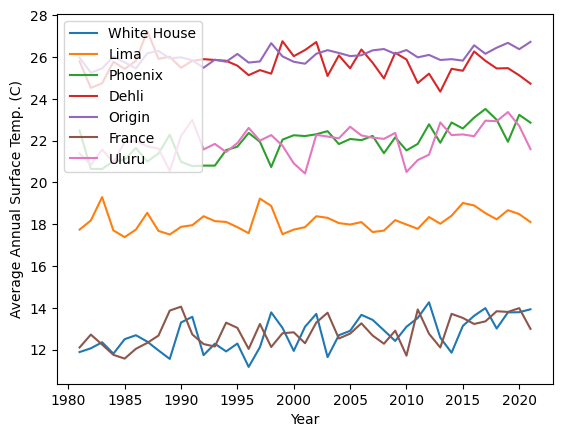

In [86]:
import matplotlib.pyplot as plt
 
xpoints = df['Year']
for loc in locs:
    ypoints = df[loc]
    plt.plot(xpoints,ypoints,label=loc)

plt.legend(loc="upper left"), plt.xlabel("Year"), plt.ylabel("Average Annual Surface Temp. (C)")
plt.show()

Here we used the ArcGIS API which loads a lot of the REST endpoint information & GetCapabilities into an imagery layer which can also be done by hardcoding in requests (e.g., [calling all TS slices](https://gis.earthdata.nasa.gov/image/rest/services/POWER/POWER_901_ANNUAL_METEOROLOGY_UTC/ImageServer/slices?multidimensionalDefinition=%7B%22variableName%22%3A%22TS%22%7D&f=html)) if you would prefer to test in the GUI before converting into Python.

Additional modules include [*arcpy*](https://www.esri.com/en-us/arcgis/products/arcgis-python-libraries/libraries/arcpy) and [*qgis*](https://docs.qgis.org/3.28/en/docs/pyqgis_developer_cookbook/index.html) for use in their respective ArcGIS Pro and QGIS platforms. Data can also be loaded and filtered using SQL queries or loading into GeoDataFrames for more pandas analysis using [*XArray*](https://docs.xarray.dev/en/stable/) if you are more comfortable in either of those environments. For all of these, documentation and tutorials [have been published](https://www.earthdata.nasa.gov/learn/pathfinders/gis-pathfinder#imageservice) with more in development based on community feedback and specific challenges.

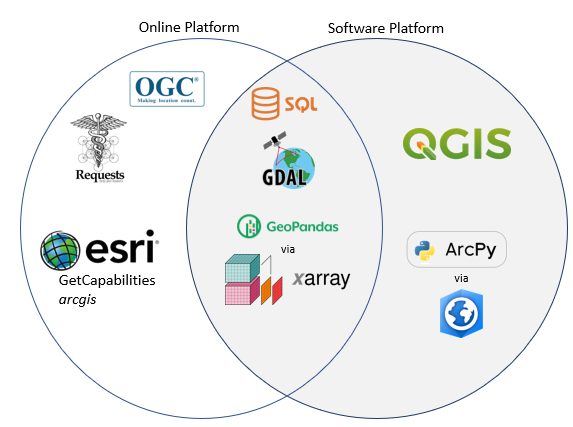